# Importar librerías y cargar datos

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Definir paths
train_dir = 'IP102_subconjunto/train'
val_dir = 'IP102_subconjunto/val'
test_dir = 'IP102_subconjunto/test'

# Generador de datos con aumento
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Tamaño de imagen y lote
img_size = (224, 224)
batch_size = 32

# Cargar datos
train_data = train_datagen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_data = val_datagen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')


Found 1956 images belonging to 10 classes.
Found 658 images belonging to 10 classes.


# Cargar imagenes de IP102

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rutas a las carpetas organizadas
train_dir = 'IP102_subconjunto/train'
val_dir = 'IP102_subconjunto/val'
test_dir = 'IP102_subconjunto/test'

# Dimensiones y parámetros
img_size = (224, 224)
batch_size = 32

# Aumento de datos para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    zoom_range=0.2, 
    horizontal_flip=True
)

# Validación y test sin aumento
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Carga de datos desde las carpetas
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 1956 images belonging to 10 classes.
Found 658 images belonging to 10 classes.
Found 1607 images belonging to 10 classes.


# Verificacion

In [17]:
print("Clases detectadas:", train_data.num_classes)
print("Total imágenes entrenamiento:", train_data.samples)
print("Total imágenes validación:", val_data.samples)
print("Total imágenes prueba:", test_data.samples)

Clases detectadas: 10
Total imágenes entrenamiento: 1956
Total imágenes validación: 658
Total imágenes prueba: 1607


# Mostrar imágenes

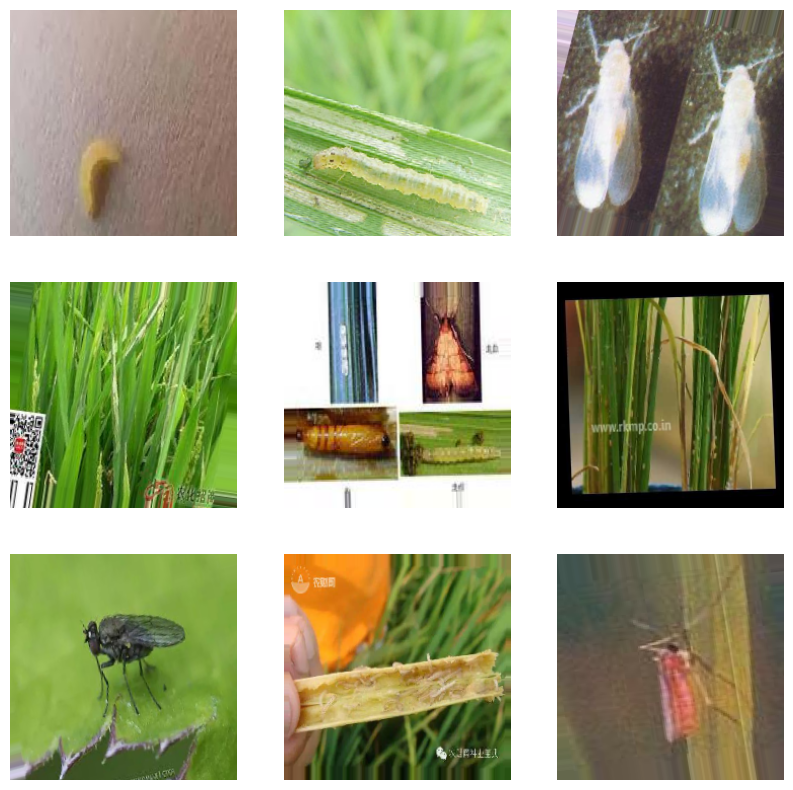

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un lote de imágenes
images, labels = next(train_data)

# Mostrar 9 imágenes
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

#  Importar librerías necesarias

In [19]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Crear el modelo con MobileNetV2

In [20]:
# Cargar la base MobileNetV2 sin la capa final (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas base para evitar que se reentrenen en esta etapa
base_model.trainable = False

# Añadir nuevas capas para la clasificación específica
x = base_model.output
x = GlobalAveragePooling2D()(x)         # Reduce a un vector
x = Dropout(0.3)(x)                      # Para evitar sobreajuste
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

# Modelo final
model = Model(inputs=base_model.input, outputs=output)

# Compilar el modelo

In [21]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

# Crear subconjunto del dataset

In [13]:
import os
import shutil
import random

# Ruta de entrada y salida
ruta_origen = 'IP102/classification'       # Donde está el dataset completo
ruta_destino = 'IP102_subconjunto'         # Nueva carpeta con dataset reducido

# Clases seleccionadas
clases_objetivo = [str(i) for i in range(10)]
max_imgs_por_clase = 200

# Particiones a procesar
particiones = ['train', 'val', 'test']

# Crear carpetas destino
for particion in particiones:
    for clase in clases_objetivo:
        os.makedirs(os.path.join(ruta_destino, particion, clase), exist_ok=True)

# Función para copiar un subconjunto de imágenes
def copiar_imagenes(particion):
    for clase in clases_objetivo:
        origen_clase = os.path.join(ruta_origen, particion, clase)
        destino_clase = os.path.join(ruta_destino, particion, clase)

        # Obtener imágenes de la clase
        imagenes = os.listdir(origen_clase)
        random.shuffle(imagenes)
        seleccionadas = imagenes[:max_imgs_por_clase]

        for img in seleccionadas:
            src = os.path.join(origen_clase, img)
            dst = os.path.join(destino_clase, img)
            shutil.copy2(src, dst)

# Ejecutar el script para cada partición
for particion in particiones:
    copiar_imagenes(particion)

print("✅ Subconjunto reducido creado correctamente en 'IP102_subconjunto'")


✅ Subconjunto reducido creado correctamente en 'IP102_subconjunto'


# ENTRENAMIENTO DEL MODELO (FASE 1 + FASE 2)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# FASE 1: Entrenar solo las capas nuevas
base_model.trainable = False
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#  Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('mejor_modelo_fase1.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

#  Entrenamiento Fase 1
history_1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
62/62 [==============================] - 157s 2s/step - loss: 2.6660 - accuracy: 0.1324 - val_loss: 2.1148 - val_accuracy: 0.2629 - lr: 1.0000e-04
Epoch 2/10
62/62 [==============================] - 36731s 602s/step - loss: 2.3305 - accuracy: 0.1912 - val_loss: 1.9853 - val_accuracy: 0.3055 - lr: 1.0000e-04
Epoch 3/10
62/62 [==============================] - 121s 2s/step - loss: 2.1359 - accuracy: 0.2454 - val_loss: 1.9037 - val_accuracy: 0.3678 - lr: 1.0000e-04
Epoch 4/10
62/62 [==============================] - 112s 2s/step - loss: 2.0209 - accuracy: 0.3057 - val_loss: 1.8391 - val_accuracy: 0.3708 - lr: 1.0000e-04
Epoch 5/10
62/62 [==============================] - 110s 2s/step - loss: 1.8918 - accuracy: 0.3298 - val_loss: 1.7970 - val_accuracy: 0.3921 - lr: 1.0000e-04
Epoch 6/10
62/62 [==============================] - 105s 2s/step - loss: 1.8549 - accuracy: 0.3384 - val_loss: 1.7649 - val_accuracy: 0.3815 - lr: 1.0000e-04
Epoch 7/10
62/62 [==============================

# FASE 2: Fine-tuning del modelo base

In [25]:
#  Descongelar el modelo base (MobileNetV2)
base_model.trainable = True

# Recompilar con tasa de aprendizaje más baja
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#  Nuevo checkpoint para fine-tuning
fine_tune_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('mejor_modelo_finetune.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

#  Entrenamiento Fase 2
history_2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=fine_tune_callbacks
)


Epoch 1/5
62/62 [==============================] - 425s 6s/step - loss: 2.0090 - accuracy: 0.2843 - val_loss: 1.6424 - val_accuracy: 0.4316 - lr: 1.0000e-05
Epoch 2/5
62/62 [==============================] - 358s 6s/step - loss: 1.8580 - accuracy: 0.3446 - val_loss: 1.6335 - val_accuracy: 0.4392 - lr: 1.0000e-05
Epoch 3/5
62/62 [==============================] - 229s 4s/step - loss: 1.8156 - accuracy: 0.3522 - val_loss: 1.6263 - val_accuracy: 0.4377 - lr: 1.0000e-05
Epoch 4/5
62/62 [==============================] - 198s 3s/step - loss: 1.7605 - accuracy: 0.3880 - val_loss: 1.6216 - val_accuracy: 0.4438 - lr: 1.0000e-05
Epoch 5/5
62/62 [==============================] - 183s 3s/step - loss: 1.7167 - accuracy: 0.4085 - val_loss: 1.6180 - val_accuracy: 0.4407 - lr: 1.0000e-05


# Graficar aficar las métricas de entrenamiento 

In [26]:
import matplotlib.pyplot as plt

def graficar_metricas(history, titulo="Fase de Entrenamiento"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.title(f'Precisión - {titulo}')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.title(f'Pérdida - {titulo}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

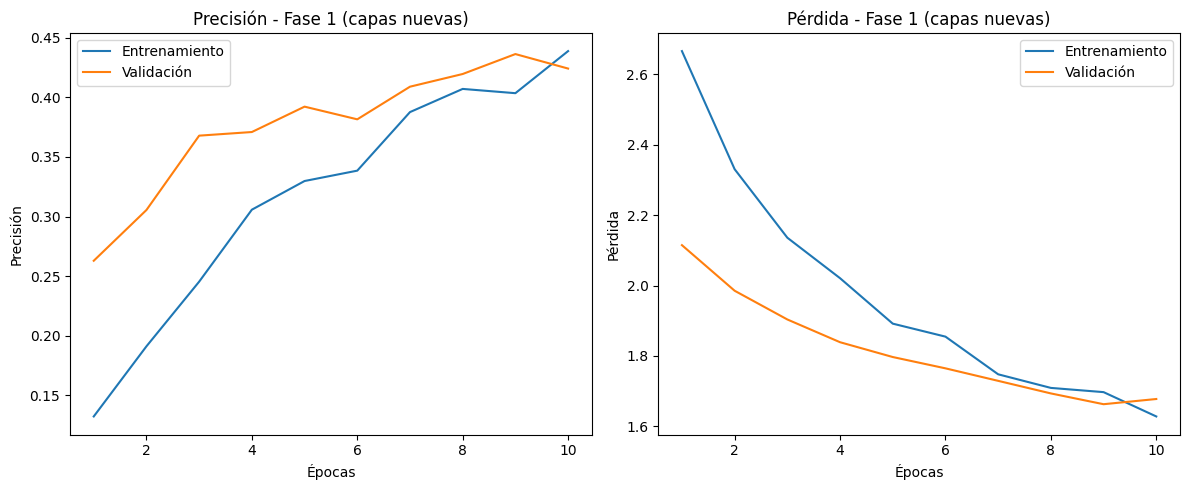

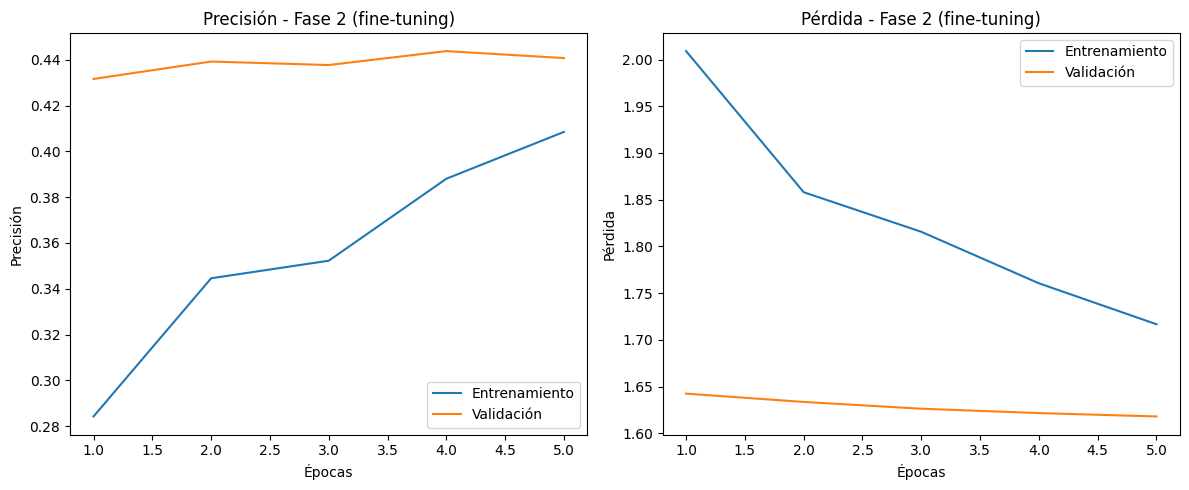

In [27]:
# Fase 1
graficar_metricas(history_1, "Fase 1 (capas nuevas)")

# Fase 2
graficar_metricas(history_2, "Fase 2 (fine-tuning)")

# Evaluar modelo entrenado

## se carga el mejor modelo entrenado guardado por los checkpoints

In [29]:
from tensorflow.keras.models import load_model

# Cargar el mejor modelo guardado de la Fase 2
modelo_final = load_model('mejor_modelo_finetune.h5')

## evualuar conjunto de datos de prueba

In [36]:
# Evaluación directa
loss, accuracy = modelo_final.evaluate(test_data)
print(f" Precisión en test: {accuracy*100:.2f}%")
print(f" Pérdida en test: {loss:.4f}")

51/51 [==============================] - 65s 1s/step - loss: 1.6193 - accuracy: 0.4350
 Precisión en test: 43.50%
 Pérdida en test: 1.6193


## predicción con imagen

1/1 [==============================] - 2s 2s/step


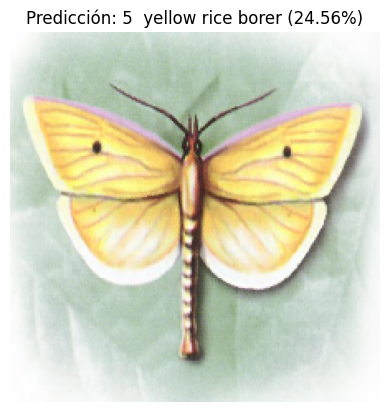

 Predicción: 5  yellow rice borer (Clase 4)
 Confianza: 24.56%


In [37]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# ✅ Ruta del modelo entrenado
modelo_final = tf.keras.models.load_model('mejor_modelo_finetune.h5')

# ✅ Ruta de la imagen que quieres predecir
ruta_imagen = 'IP102_subconjunto/test/4/03093.jpg'  # 🔁 cámbiala por la imagen que desees

# ✅ Tamaño usado en entrenamiento
img_size = (224, 224)

# 📸 Cargar y procesar la imagen
img = image.load_img(ruta_imagen, target_size=img_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 🔮 Realizar predicción
prediccion = modelo_final.predict(img_array)
indice_clase = np.argmax(prediccion)
confianza = prediccion[0][indice_clase] * 100

# ✅ Leer nombres de clases desde classes.txt
ruta_classes = 'IP102_subconjunto/classes.txt'
with open(ruta_classes, 'r') as f:
    clases = [line.strip() for line in f.readlines()]

nombre_clase = clases[indice_clase] if indice_clase < len(clases) else f"Clase {indice_clase}"

# 🖼️ Mostrar imagen con resultado
plt.imshow(img)
plt.title(f"Predicción: {nombre_clase} ({confianza:.2f}%)")
plt.axis('off')
plt.show()

# 📝 Resultado por consola
print(f" Predicción: {nombre_clase} (Clase {indice_clase})")
print(f" Confianza: {confianza:.2f}%")

1/1 [==============================] - 1s 1s/step


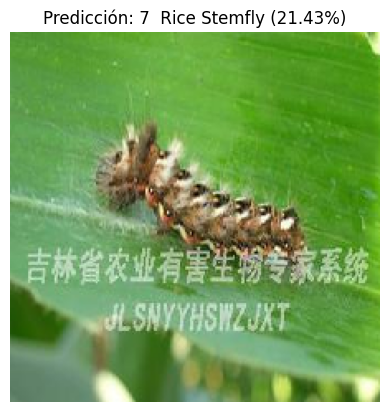

 Predicción: 7  Rice Stemfly (Clase 6)
 Confianza: 21.43%


In [38]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# ✅ Ruta del modelo entrenado
modelo_final = tf.keras.models.load_model('mejor_modelo_finetune.h5')

# ✅ Ruta de la imagen que quieres predecir
ruta_imagen = 'IP102_subconjunto/test/1/01214.jpg'  # 🔁 cámbiala por la imagen que desees

# ✅ Tamaño usado en entrenamiento
img_size = (224, 224)

# 📸 Cargar y procesar la imagen
img = image.load_img(ruta_imagen, target_size=img_size)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# 🔮 Realizar predicción
prediccion = modelo_final.predict(img_array)
indice_clase = np.argmax(prediccion)
confianza = prediccion[0][indice_clase] * 100

# ✅ Leer nombres de clases desde classes.txt
ruta_classes = 'IP102_subconjunto/classes.txt'
with open(ruta_classes, 'r') as f:
    clases = [line.strip() for line in f.readlines()]

nombre_clase = clases[indice_clase] if indice_clase < len(clases) else f"Clase {indice_clase}"

# 🖼️ Mostrar imagen con resultado
plt.imshow(img)
plt.title(f"Predicción: {nombre_clase} ({confianza:.2f}%)")
plt.axis('off')
plt.show()

# 📝 Resultado por consola
print(f" Predicción: {nombre_clase} (Clase {indice_clase})")
print(f" Confianza: {confianza:.2f}%")

In [34]:
import sklearn
print(sklearn.__version__)

1.3.2


51/51 [==============================] - 67s 1s/step


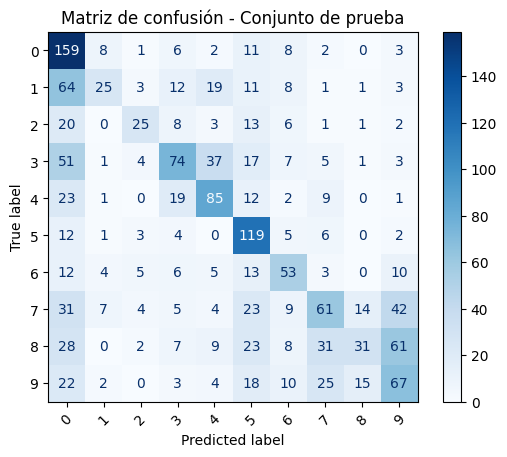

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Paso 1: Obtener predicciones
y_pred_probs = modelo_final.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Paso 2: Obtener etiquetas reales
y_true = test_data.classes

# Paso 3: Generar la matriz de confusión
matriz = confusion_matrix(y_true, y_pred)

# Paso 4: Mostrar la matriz
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=test_data.class_indices.keys())
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de confusión - Conjunto de prueba")
plt.grid(False)
plt.show()